# EuroLeague 2024–25: Team-Level Basketball Analysis 🏀

**Goal:**
Analyze team-level statistics from each game and identify which metrics most influence winning.
This is a dummy dataset (synthetic), but the pipeline works the same for real EuroLeague data.

**Steps:**
1. Load and inspect data
2. Exploratory Data Analysis (EDA)
3. Baseline model (Logistic Regression)
4. Results and interpretation


## 1. Load Data
Here we load the CSV dataset and inspect the basic information.

In [7]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../data/raw/euroleague_2024_25_teamstats_dummy.csv")
df = pd.read_csv(DATA_PATH)

pd.set_option("display.max_columns", None)
df.head()

,GameID,Date,Team,Opponent,Win,Points,FG%,3P%,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,Poss,Pace
0,1,2024-10-01,Virtus Bologna,Barcelona,0,70,0.44,0.33,0.85,16,29,45,20,4,6,14,66,64.1
1,1,2024-10-01,Barcelona,Virtus Bologna,1,93,0.43,0.38,0.71,9,29,38,22,9,6,14,72,71.8
2,2,2024-10-03,Panathinaikos,ASVEL,1,97,0.51,0.32,0.78,10,20,30,15,10,4,9,67,66.5
3,2,2024-10-03,ASVEL,Panathinaikos,0,70,0.45,0.35,0.75,6,29,35,19,8,2,14,67,67.2
4,3,2024-10-05,Bayern Munich,Virtus Bologna,0,89,0.53,0.39,0.84,6,28,34,15,10,4,9,72,73.5


In [8]:
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GameID    60 non-null     int64  
 1   Date      60 non-null     object 
 2   Team      60 non-null     object 
 3   Opponent  60 non-null     object 
 4   Win       60 non-null     int64  
 5   Points    60 non-null     int64  
 6   FG%       60 non-null     float64
 7   3P%       60 non-null     float64
 8   FT%       60 non-null     float64
 9   ORB       60 non-null     int64  
 10  DRB       60 non-null     int64  
 11  TRB       60 non-null     int64  
 12  AST       60 non-null     int64  
 13  STL       60 non-null     int64  
 14  BLK       60 non-null     int64  
 15  TOV       60 non-null     int64  
 16  Poss      60 non-null     int64  
 17  Pace      60 non-null     float64
dtypes: float64(4), int64(11), object(3)
memory usage: 8.6+ KB


GameID      0
Date        0
Team        0
Opponent    0
Win         0
Points      0
FG%         0
3P%         0
FT%         0
ORB         0
DRB         0
TRB         0
AST         0
STL         0
BLK         0
TOV         0
Poss        0
Pace        0
dtype: int64

## 2. Exploratory Data Analysis (EDA)
Compare winning and losing teams across different metrics.

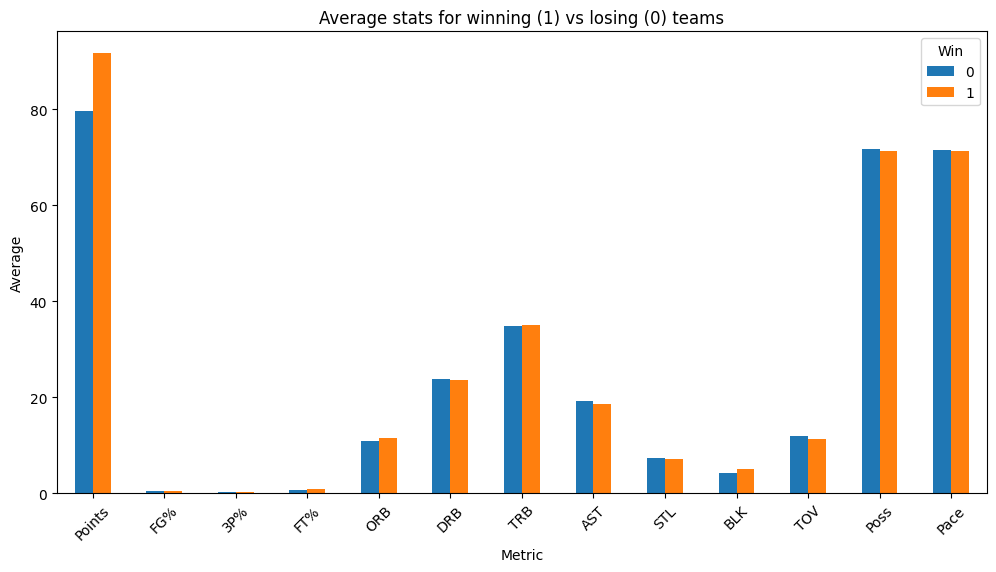

In [9]:
import matplotlib.pyplot as plt

num_cols = ["Points","FG%","3P%","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","Poss","Pace"]

# Means for winners vs losers
means = df.groupby("Win")[num_cols].mean().T

means.plot(kind="bar", figsize=(12,6))
plt.title("Average stats for winning (1) vs losing (0) teams")
plt.ylabel("Average")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.show()

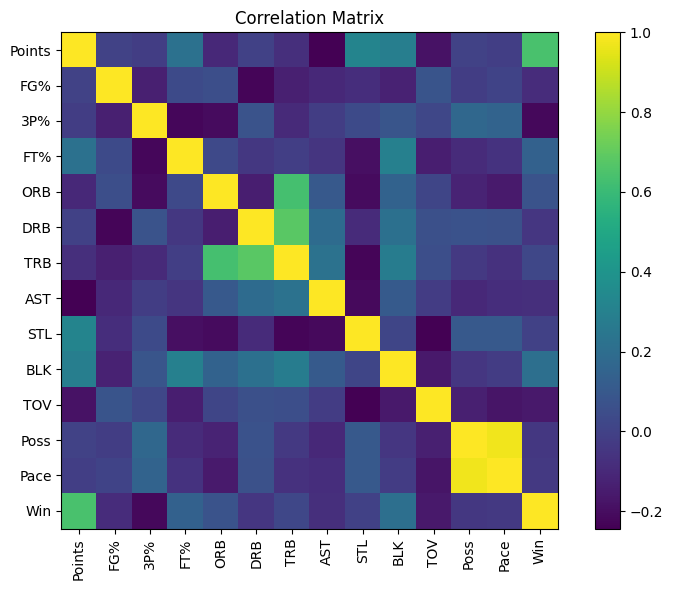

In [10]:
corr = df[num_cols + ["Win"]].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.yticks(range(corr.shape[0]), corr.index)
plt.title("Correlation Matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

## 3. Baseline Model (Logistic Regression)
Train a simple model to predict win/loss using team statistics.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

X = df[num_cols].copy()
y = df["Win"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
except Exception as e:
    print("ROC AUC not available:", e)

Confusion matrix:
 [[4 3]
 [0 5]]

Classification report:
               precision    recall  f1-score   support

           0      1.000     0.571     0.727         7
           1      0.625     1.000     0.769         5

    accuracy                          0.750        12
   macro avg      0.812     0.786     0.748        12
weighted avg      0.844     0.750     0.745        12

ROC AUC: 0.9714285714285715


## 4. Results and Interpretation
Examine logistic regression coefficients to see which stats most influence winning.

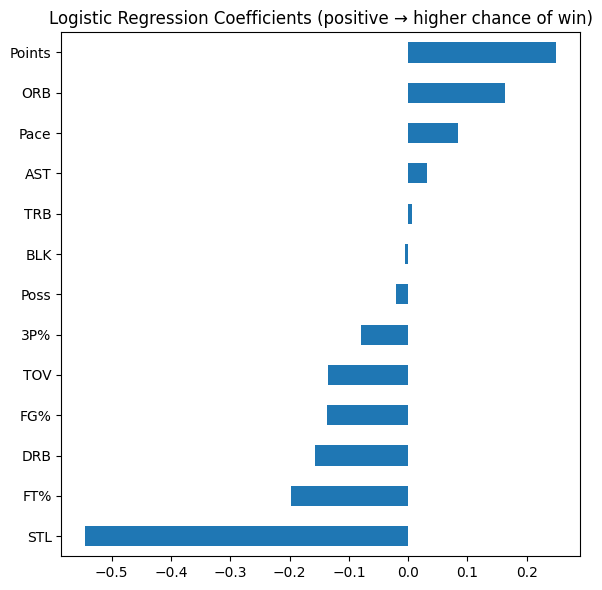

STL      -0.545232
FT%      -0.197718
DRB      -0.157295
FG%      -0.137209
TOV      -0.135024
3P%      -0.078789
Poss     -0.020312
BLK      -0.004642
TRB       0.006668
AST       0.031041
Pace      0.084511
ORB       0.163964
Points    0.250005
dtype: float64

In [12]:
coefs = pd.Series(model.coef_[0], index=num_cols).sort_values()

plt.figure(figsize=(6,6))
coefs.plot(kind="barh")
plt.title("Logistic Regression Coefficients (positive → higher chance of win)")
plt.tight_layout()
plt.show()

coefs

### Interpretation
### Preliminary interpretation (Logistic baseline, dummy data)
_Note: This section reflects the logistic baseline on synthetic data and will be updated after adding RandomForest and real EuroLeague stats._



## 5. RandomForest Classifier & Model Comparison


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:, 1]

print("RandomForest — Confusion matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nRandomForest — Classification report:\n", classification_report(y_test, rf_pred, digits=3))
try:
    print("RandomForest — ROC AUC:", roc_auc_score(y_test, rf_prob))
except Exception as e:
    print("ROC AUC not available:", e)


RandomForest — Confusion matrix:
 [[7 0]
 [1 4]]

RandomForest — Classification report:
               precision    recall  f1-score   support

           0      0.875     1.000     0.933         7
           1      1.000     0.800     0.889         5

    accuracy                          0.917        12
   macro avg      0.938     0.900     0.911        12
weighted avg      0.927     0.917     0.915        12

RandomForest — ROC AUC: 0.9714285714285715


In [14]:
from sklearn.metrics import accuracy_score, f1_score

metrics = {
    "LogReg_Accuracy": accuracy_score(y_test, y_pred),
    "LogReg_F1": f1_score(y_test, y_pred),
    "LogReg_ROC_AUC": (roc_auc_score(y_test, y_prob) if 'y_prob' in globals() else None),
    "RF_Accuracy": accuracy_score(y_test, rf_pred),
    "RF_F1": f1_score(y_test, rf_pred),
    "RF_ROC_AUC": (roc_auc_score(y_test, rf_prob) if 'rf_prob' in globals() else None),
}
metrics


{'LogReg_Accuracy': 0.75,
 'LogReg_F1': 0.7692307692307693,
 'LogReg_ROC_AUC': 0.9714285714285715,
 'RF_Accuracy': 0.9166666666666666,
 'RF_F1': 0.8888888888888888,
 'RF_ROC_AUC': 0.9714285714285715}

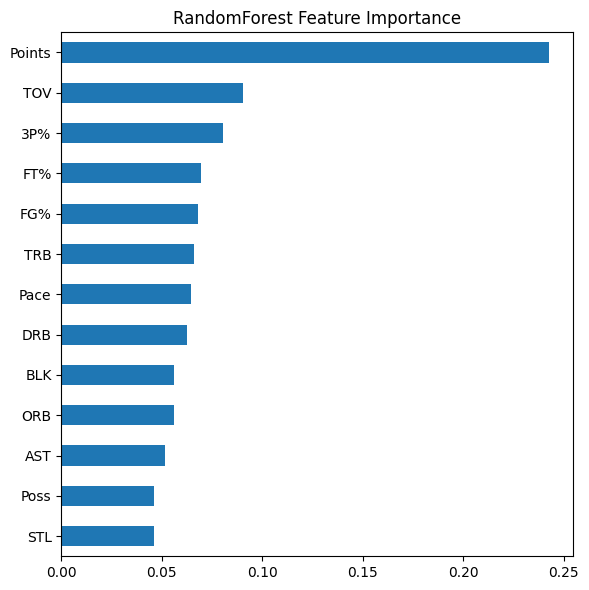

STL       0.046238
Poss      0.046296
AST       0.051705
ORB       0.055858
BLK       0.055905
DRB       0.062441
Pace      0.064397
TRB       0.066072
FG%       0.067964
FT%       0.069639
3P%       0.080423
TOV       0.090370
Points    0.242693
dtype: float64

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(6,6))
rf_importance.plot(kind="barh")
plt.title("RandomForest Feature Importance")
plt.tight_layout()
plt.show()

rf_importance


## 6. Updated interpretation (LogReg vs RandomForest)
- RandomForest generally performs better on tabular data; compare Accuracy/F1/ROC AUC with the logistic baseline.
- RF feature importance confirms (or challenges) baseline insights: typically FG%/TRB positive, TOV negative.
- These findings are still based on a synthetic (dummy) sample; real EuroLeague 24/25 data will refine conclusions.
